<!-- # Summarization model -->

In [1]:

import torch
import torch.nn as nn
import json

seed = 42
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU
torch.cuda.manual_seed_all(seed)  # Multi-GPU

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os


PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
GPU count: 1
Using device: cuda


# Load dataset

In [2]:

from datasets import load_dataset

ds = load_dataset("FrancophonIA/french-to-english", split="train", streaming=True)
print(ds)

IterableDataset({
    features: Unknown,
    num_shards: 1
})


# Get Tokenizer - BartTokenizer with 50265 vocab size

In [3]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
VOCAB_SIZE = tokenizer.vocab_size

SRC_MAX_SEQ = 50
TGT_MAX_SEQ = 50
max_examples = 600000

# Prepare data - save data

In [4]:
from transformers import pipeline

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt, device=device)

Device set to use cuda


In [ ]:

# inputs = []
# outputs = []
# i = 0
# for data in ds:
#     src_sentence = tokenizer.encode(str(data['en']))
#     tgt_sentence = tokenizer.encode(str(data['fr']))
#     if len(src_sentence) <= SRC_MAX_SEQ and len(tgt_sentence) <= TGT_MAX_SEQ:
#         try:
#             if not data.get('fr') or not isinstance(data['fr'], str):
#                 continue  # Skip invalid entries
#             else:
#                 res = pipe(data['fr'], top_k=1, truncation=True)[0]['label']
#                 if res == 'fr':       
#                     inputs.append(src_sentence)
#                     outputs.append(tgt_sentence)
#                     i += 1
#         except Exception as e:
#             print(f"Error {e}")
#             continue       
#     if i == max_examples:
#         break
# # Save as JSON
# with open('tokenized_data.json', 'w') as f:
#     json.dump({'inputs': inputs, 'outputs': outputs}, f)

# Load data

In [6]:
inputs = []
outputs = []

with open('tokenized_data.json', 'r') as f:
    data = json.load(f)
    inputs = data['inputs'][:max_examples]
    outputs = data['outputs'][:max_examples]
print(len(inputs), len(outputs))
# for inp, out in zip(inputs, outputs):
#     out = tokenizer.decode(out, skip_special_tokens=True)
#     inp = tokenizer.decode(inp, skip_special_tokens=True)
#     # print(inp)
#     # print(out)
#     # print()
#     res = pipe(out, top_k=1, truncation=True)[0]['label']
#     if res != 'fr':
#         print(res, out)

600000 600000


# Clean data

In [7]:
"""To set determined len for src and tgt --> also with pad tokens"""


def clean_data(sentences, max_seq_length):
    for i, sentence in enumerate(sentences):
        if len(sentence) < max_seq_length:
            sentences[i] = sentence + [tokenizer.pad_token_id] * (max_seq_length - len(sentence))


clean_data(inputs, SRC_MAX_SEQ)
clean_data(outputs, TGT_MAX_SEQ)

In [8]:
for step, (inp, out) in enumerate(zip(inputs, outputs)):
    print(tokenizer.decode(inp, skip_special_tokens=True), '######', tokenizer.decode(out, skip_special_tokens=True))
    if step == 10:
        break

Site map ###### Plan du site
Feedback ###### Rétroaction
Credits ###### Crédits
What is light ? ###### Qu’est-ce que la lumière?
The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone ###### Le ciel des premiers habitants La vision contemporaine de l'Univers L’astronomie pour tous
Cartoon ###### Bande dessinée
Astronomers Introduction Introduction video What is Astronomy? ###### Astronomes Introduction Vidéo d'introduction Qu'est-ce que l'astronomie?
The name is derived from the Greek root astron for star, and nomos for arrangement or law. ###### Son nom vient du grec astron, qui veut dire étoile et nomos, qui veut dire loi.
It prompts us to ask the deepest existential questions: ###### L'astronomie évoque donc aussi les grandes questions « existentielles » :
Who are we? ###### Où sommes-nous?
Where did we come from? ###### D'où venons-nous?


In [9]:
inputs = torch.tensor(inputs)
targets = torch.tensor(outputs)
assert len(inputs) == len(targets), "Number of articles and summaries must be the same"
print('Max src seq len:', SRC_MAX_SEQ)
print('Max tgt seq len:', TGT_MAX_SEQ)
print('Number of examples:', len(inputs))
print("Number of vocab size:", VOCAB_SIZE)

Max src seq len: 50
Max tgt seq len: 50
Number of examples: 600000
Number of vocab size: 50265


# Custom Dataset and DataLoader with train and val data (80%, 20%)

In [10]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


dataset = CustomDataset(inputs, targets)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 480000
Number of validation samples: 120000


In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128  # TODO: expand batch size for transformer architecture

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")


Number of batches in training set: 3750
Number of batches in validation set: 938


In [12]:
print(tokenizer.decode(train_loader.dataset[0][0], skip_special_tokens=True) )
print(tokenizer.decode(train_loader.dataset[0][1], skip_special_tokens=True) )

An Action Plan to Reduce Greenhouse Gases and Air Pollution  13.
Services électroniques aux importateurs et aux exportateurs - Agence des services frontaliers du Canada (ASFC)  27.


In [13]:
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads 

        self.W_q = nn.Linear(d_model, d_model)  # Query transformation
        self.W_k = nn.Linear(d_model, d_model)  # Key transformation
        self.W_v = nn.Linear(d_model, d_model)  # Value transformation
        self.W_o = nn.Linear(d_model, d_model)  # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # TODO: use F..scaled_dot_product_attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [14]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # Assumption: GELU outperforms ReLU which leads to 'ReLU dead neuron problem': https://arxiv.org/pdf/1606.08415
        self.gelu = nn.GELU(approximate='tanh')

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

In [15]:
"""NOTE: There is no evidence that positional encoding is better than simple learnable embeddings."""

#
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()
#
#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#
#         self.register_buffer('pe', pe.unsqueeze(0))
#
#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]

'NOTE: There is no evidence that positional encoding is better than simple learnable embeddings.'

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  # TODO: one dropout layer or two?

    def forward(self, x, mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)  # residual_x described at: https://arxiv.org/pdf/1904.10509
        attn_output = self.self_attn(residual_x, residual_x, residual_x, mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)
        attn_output = self.self_attn(residual_x, residual_x, residual_x, tgt_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        attn_output = self.cross_attn(residual_x, enc_output, enc_output, src_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm3(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [18]:



class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                 max_tgt_seq_len, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # self.src_positional_encoding = PositionalEncoding(d_model, max_src_seq_len)
        # self.tgt_positional_encoding = PositionalEncoding(d_model, max_tgt_seq_len)
        self.src_positional_encoding = nn.Embedding(max_src_seq_len,
                                                    d_model)  # instead of cos and sin functions (in PositionalEncoding)
        self.tgt_positional_encoding = nn.Embedding(max_tgt_seq_len, d_model)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        self.ln_f = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size,
                                      bias=False)  # bias=False as depicted: https://github.com/karpathy/nanoGPT/blob/master/model.py
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(3)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        seq_length = tgt.size(1)
        casual_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        casual_mask = casual_mask.to(device)
        tgt_mask = tgt_mask & casual_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # src_embedded = self.dropout(self.src_positional_encoding(self.encoder_embedding(src)))
        # tgt_embedded = self.dropout(self.tgt_positional_encoding(self.decoder_embedding(tgt)))

        src_pos = torch.arange(0, src.size(1)).to(device)  # [0, 1, 2 ... src.size(1)]
        src_pos = self.src_positional_encoding(src_pos)
        src_embedded = self.encoder_embedding(src)
        src_embedded = self.dropout(src_pos + src_embedded)

        tgt_pos = torch.arange(0, tgt.size(1)).to(device)
        tgt_pos = self.tgt_positional_encoding(tgt_pos)
        tgt_embedded = self.decoder_embedding(tgt)
        tgt_embedded = self.dropout(tgt_pos + tgt_embedded)

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        dec_output = self.ln_f(dec_output)
        output = self.output_layer(dec_output)
        return output

In [19]:
src_vocab_size = VOCAB_SIZE
tgt_vocab_size = VOCAB_SIZE
d_model = 128  # TODO: experiment with model complexity - it can lead to overfitting
num_heads = 1  # TODO: layers + heads have impact on final results: https://medium.com/@ccibeekeoc42/unveiling-the-transformer-impact-of-layers-and-attention-heads-in-audio-classification-58747d52b794
num_layers = 6  # TODO: how many layers? as above, model complexity; smaller BART uses 6: https://arxiv.org/pdf/1910.13461
d_ff = d_model * 4
max_src_seq_len = SRC_MAX_SEQ
max_tgt_seq_len = TGT_MAX_SEQ
dropout = 0.1

In [20]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                          max_tgt_seq_len,
                          dropout)
transformer.to(device)
num_parameters = sum(p.numel() for p in transformer.parameters())
print(f"Number of parameters: {num_parameters/1000000} M")


Number of parameters: 22.091904 M


# Train model

In [21]:
import torch
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

lr = 0.0007
optimizer = optim.Adam(
    transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.00
)

# TODO: experiment with gradient accumulation
num_epochs = 150
# TODO: add warmup steps
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps) # TODO: experiment with that
 
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Tracking history
lr_history = []
loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    transformer.train()

    # Progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for step, (src_data, tgt_data) in enumerate(progress_bar):
        src_data, tgt_data = src_data.to(device), tgt_data.to(device)

        # Forward pass
        output = transformer(src_data, tgt_data[:, :-1])

        # Compute loss
        loss = F.cross_entropy(
            output.contiguous().view(-1, tgt_vocab_size),
            tgt_data[:, 1:].contiguous().view(-1),
            ignore_index=tokenizer.pad_token_id
        )

        # Track loss
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        lr_history.append(optimizer.param_groups[0]["lr"])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_epoch_loss:.4f}")

    transformer.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_src_data, val_tgt_data in val_loader:
            val_src_data, val_tgt_data = val_src_data.to(device), val_tgt_data.to(device)

            # Forward pass
            val_output = transformer(val_src_data, val_tgt_data[:, :-1])

            val_loss = F.cross_entropy(
                val_output.contiguous().view(-1, tgt_vocab_size),
                val_tgt_data[:, 1:].contiguous().view(-1),
                ignore_index=tokenizer.pad_token_id
            )

            total_val_loss += val_loss.item()

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")


Epoch 1: 100%|██████████| 3750/3750 [05:14<00:00, 11.92it/s, Batch Loss=5.53]


Epoch: 1, Loss: 7.7274
Average Validation Loss: 5.4194


Epoch 2: 100%|██████████| 3750/3750 [05:16<00:00, 11.84it/s, Batch Loss=4.1] 


Epoch: 2, Loss: 4.6472
Average Validation Loss: 3.8901


Epoch 3: 100%|██████████| 3750/3750 [05:17<00:00, 11.83it/s, Batch Loss=3.52]


Epoch: 3, Loss: 3.7125
Average Validation Loss: 3.2745


Epoch 4: 100%|██████████| 3750/3750 [05:16<00:00, 11.84it/s, Batch Loss=3.08]


Epoch: 4, Loss: 3.2436
Average Validation Loss: 2.9065


Epoch 5: 100%|██████████| 3750/3750 [05:17<00:00, 11.82it/s, Batch Loss=2.82]


Epoch: 5, Loss: 2.9309
Average Validation Loss: 2.6398


Epoch 6: 100%|██████████| 3750/3750 [05:17<00:00, 11.82it/s, Batch Loss=2.52]


Epoch: 6, Loss: 2.7004
Average Validation Loss: 2.4353


Epoch 7: 100%|██████████| 3750/3750 [05:16<00:00, 11.85it/s, Batch Loss=2.28]


Epoch: 7, Loss: 2.5144
Average Validation Loss: 2.2608


Epoch 8: 100%|██████████| 3750/3750 [05:16<00:00, 11.84it/s, Batch Loss=2.08]


Epoch: 8, Loss: 2.3595
Average Validation Loss: 2.1248


Epoch 9: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=2.24]


Epoch: 9, Loss: 2.2368
Average Validation Loss: 2.0234


Epoch 10: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=2.05]


Epoch: 10, Loss: 2.1421
Average Validation Loss: 1.9372


Epoch 11: 100%|██████████| 3750/3750 [05:13<00:00, 11.96it/s, Batch Loss=2.07]


Epoch: 11, Loss: 2.0676
Average Validation Loss: 1.8760


Epoch 12: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=2.01]


Epoch: 12, Loss: 2.0092
Average Validation Loss: 1.8338


Epoch 13: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.98]


Epoch: 13, Loss: 1.9610
Average Validation Loss: 1.7910


Epoch 14: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.87]


Epoch: 14, Loss: 1.9190
Average Validation Loss: 1.7640


Epoch 15: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.93]


Epoch: 15, Loss: 1.8830
Average Validation Loss: 1.7266


Epoch 16: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.92]


Epoch: 16, Loss: 1.8464
Average Validation Loss: 1.6971


Epoch 17: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.87]


Epoch: 17, Loss: 1.8082
Average Validation Loss: 1.6627


Epoch 18: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.78]


Epoch: 18, Loss: 1.7751
Average Validation Loss: 1.6371


Epoch 19: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.82]


Epoch: 19, Loss: 1.7465
Average Validation Loss: 1.6153


Epoch 20: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.65]


Epoch: 20, Loss: 1.7224
Average Validation Loss: 1.6015


Epoch 21: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.7] 


Epoch: 21, Loss: 1.7012
Average Validation Loss: 1.5868


Epoch 22: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.76]


Epoch: 22, Loss: 1.6824
Average Validation Loss: 1.5673


Epoch 23: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.65]


Epoch: 23, Loss: 1.6658
Average Validation Loss: 1.5555


Epoch 24: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.7] 


Epoch: 24, Loss: 1.6496
Average Validation Loss: 1.5428


Epoch 25: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.68]


Epoch: 25, Loss: 1.6352
Average Validation Loss: 1.5340


Epoch 26: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.57]


Epoch: 26, Loss: 1.6206
Average Validation Loss: 1.5218


Epoch 27: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.52]


Epoch: 27, Loss: 1.6071
Average Validation Loss: 1.5134


Epoch 28: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.65]


Epoch: 28, Loss: 1.5946
Average Validation Loss: 1.5029


Epoch 29: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.67]


Epoch: 29, Loss: 1.5836
Average Validation Loss: 1.4883


Epoch 30: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.56]


Epoch: 30, Loss: 1.5727
Average Validation Loss: 1.4917


Epoch 31: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.57]


Epoch: 31, Loss: 1.5624
Average Validation Loss: 1.4786


Epoch 32: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.63]


Epoch: 32, Loss: 1.5528
Average Validation Loss: 1.4700


Epoch 33: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.52]


Epoch: 33, Loss: 1.5446
Average Validation Loss: 1.4655


Epoch 34: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.57]


Epoch: 34, Loss: 1.5361
Average Validation Loss: 1.4601


Epoch 35: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.48]


Epoch: 35, Loss: 1.5278
Average Validation Loss: 1.4532


Epoch 36: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.55]


Epoch: 36, Loss: 1.5185
Average Validation Loss: 1.4475


Epoch 37: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.46]


Epoch: 37, Loss: 1.5100
Average Validation Loss: 1.4411


Epoch 38: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.41]


Epoch: 38, Loss: 1.5032
Average Validation Loss: 1.4339


Epoch 39: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.58]


Epoch: 39, Loss: 1.4977
Average Validation Loss: 1.4350


Epoch 40: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.37]


Epoch: 40, Loss: 1.4925
Average Validation Loss: 1.4356


Epoch 41: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.59]


Epoch: 41, Loss: 1.4861
Average Validation Loss: 1.4260


Epoch 42: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.42]


Epoch: 42, Loss: 1.4797
Average Validation Loss: 1.4241


Epoch 43: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.48]


Epoch: 43, Loss: 1.4741
Average Validation Loss: 1.4216


Epoch 44: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.46]


Epoch: 44, Loss: 1.4684
Average Validation Loss: 1.4133


Epoch 45: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.49]


Epoch: 45, Loss: 1.4639
Average Validation Loss: 1.4126


Epoch 46: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.61]


Epoch: 46, Loss: 1.4591
Average Validation Loss: 1.4066


Epoch 47: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.56]


Epoch: 47, Loss: 1.4544
Average Validation Loss: 1.4018


Epoch 48: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.64]


Epoch: 48, Loss: 1.4498
Average Validation Loss: 1.4024


Epoch 49: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.46]


Epoch: 49, Loss: 1.4448
Average Validation Loss: 1.3985


Epoch 50: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.5] 


Epoch: 50, Loss: 1.4401
Average Validation Loss: 1.3944


Epoch 51: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.46]


Epoch: 51, Loss: 1.4359
Average Validation Loss: 1.3910


Epoch 52: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.36]


Epoch: 52, Loss: 1.4315
Average Validation Loss: 1.3879


Epoch 53: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.46]


Epoch: 53, Loss: 1.4283
Average Validation Loss: 1.3862


Epoch 54: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.59]


Epoch: 54, Loss: 1.4243
Average Validation Loss: 1.3823


Epoch 55: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.61]


Epoch: 55, Loss: 1.4203
Average Validation Loss: 1.3805


Epoch 56: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.4] 


Epoch: 56, Loss: 1.4172
Average Validation Loss: 1.3745


Epoch 57: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.44]


Epoch: 57, Loss: 1.4135
Average Validation Loss: 1.3776


Epoch 58: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.47]


Epoch: 58, Loss: 1.4101
Average Validation Loss: 1.3722


Epoch 59: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.46]


Epoch: 59, Loss: 1.4066
Average Validation Loss: 1.3740


Epoch 60: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.56]


Epoch: 60, Loss: 1.4035
Average Validation Loss: 1.3704


Epoch 61: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.35]


Epoch: 61, Loss: 1.4004
Average Validation Loss: 1.3697


Epoch 62: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.36]


Epoch: 62, Loss: 1.3981
Average Validation Loss: 1.3651


Epoch 63: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.3] 


Epoch: 63, Loss: 1.3949
Average Validation Loss: 1.3616


Epoch 64: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.44]


Epoch: 64, Loss: 1.3916
Average Validation Loss: 1.3612


Epoch 65: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.41]


Epoch: 65, Loss: 1.3888
Average Validation Loss: 1.3599


Epoch 66: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.42]


Epoch: 66, Loss: 1.3857
Average Validation Loss: 1.3610


Epoch 67: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.55]


Epoch: 67, Loss: 1.3835
Average Validation Loss: 1.3562


Epoch 68: 100%|██████████| 3750/3750 [05:12<00:00, 12.01it/s, Batch Loss=1.44]


Epoch: 68, Loss: 1.3812
Average Validation Loss: 1.3590


Epoch 69: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.39]


Epoch: 69, Loss: 1.3793
Average Validation Loss: 1.3597


Epoch 70: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.33]


Epoch: 70, Loss: 1.3777
Average Validation Loss: 1.3544


Epoch 71: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.34]


Epoch: 71, Loss: 1.3755
Average Validation Loss: 1.3537


Epoch 72: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.37]


Epoch: 72, Loss: 1.3742
Average Validation Loss: 1.3501


Epoch 73: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.41]


Epoch: 73, Loss: 1.3722
Average Validation Loss: 1.3526


Epoch 74: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.33]


Epoch: 74, Loss: 1.3707
Average Validation Loss: 1.3506


Epoch 75: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.29]


Epoch: 75, Loss: 1.3686
Average Validation Loss: 1.3479


Epoch 76: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.47]


Epoch: 76, Loss: 1.3662
Average Validation Loss: 1.3500


Epoch 77: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.41]


Epoch: 77, Loss: 1.3643
Average Validation Loss: 1.3473


Epoch 78: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.33]


Epoch: 78, Loss: 1.3624
Average Validation Loss: 1.3438


Epoch 79: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.29]


Epoch: 79, Loss: 1.3597
Average Validation Loss: 1.3435


Epoch 80: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.4] 


Epoch: 80, Loss: 1.3575
Average Validation Loss: 1.3427


Epoch 81: 100%|██████████| 3750/3750 [05:13<00:00, 11.95it/s, Batch Loss=1.28]


Epoch: 81, Loss: 1.3553
Average Validation Loss: 1.3389


Epoch 82: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.36]


Epoch: 82, Loss: 1.3528
Average Validation Loss: 1.3371


Epoch 83: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.45]


Epoch: 83, Loss: 1.3505
Average Validation Loss: 1.3387


Epoch 84: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.35]


Epoch: 84, Loss: 1.3478
Average Validation Loss: 1.3369


Epoch 85: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.2] 


Epoch: 85, Loss: 1.3454
Average Validation Loss: 1.3317


Epoch 86: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.45]


Epoch: 86, Loss: 1.3423
Average Validation Loss: 1.3338


Epoch 87: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.31]


Epoch: 87, Loss: 1.3394
Average Validation Loss: 1.3319


Epoch 88: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.28]


Epoch: 88, Loss: 1.3370
Average Validation Loss: 1.3289


Epoch 89: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.4] 


Epoch: 89, Loss: 1.3345
Average Validation Loss: 1.3296


Epoch 90: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.51]


Epoch: 90, Loss: 1.3335
Average Validation Loss: 1.3251


Epoch 91: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.16]


Epoch: 91, Loss: 1.3311
Average Validation Loss: 1.3251


Epoch 92: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.32]


Epoch: 92, Loss: 1.3284
Average Validation Loss: 1.3235


Epoch 93: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.29]


Epoch: 93, Loss: 1.3267
Average Validation Loss: 1.3221


Epoch 94: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.4] 


Epoch: 94, Loss: 1.3250
Average Validation Loss: 1.3251


Epoch 95: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.26]


Epoch: 95, Loss: 1.3235
Average Validation Loss: 1.3213


Epoch 96: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.27]


Epoch: 96, Loss: 1.3219
Average Validation Loss: 1.3195


Epoch 97: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.44]


Epoch: 97, Loss: 1.3207
Average Validation Loss: 1.3196


Epoch 98: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.25]


Epoch: 98, Loss: 1.3188
Average Validation Loss: 1.3179


Epoch 99: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.3] 


Epoch: 99, Loss: 1.3170
Average Validation Loss: 1.3176


Epoch 100: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.21]


Epoch: 100, Loss: 1.3155
Average Validation Loss: 1.3131


Epoch 101: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.38]


Epoch: 101, Loss: 1.3138
Average Validation Loss: 1.3148


Epoch 102: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.35]


Epoch: 102, Loss: 1.3127
Average Validation Loss: 1.3182


Epoch 103: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.34]


Epoch: 103, Loss: 1.3112
Average Validation Loss: 1.3135


Epoch 104: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.28]


Epoch: 104, Loss: 1.3103
Average Validation Loss: 1.3162


Epoch 105: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.21]


Epoch: 105, Loss: 1.3092
Average Validation Loss: 1.3110


Epoch 106: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.28]


Epoch: 106, Loss: 1.3080
Average Validation Loss: 1.3099


Epoch 107: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.29]


Epoch: 107, Loss: 1.3065
Average Validation Loss: 1.3129


Epoch 108: 100%|██████████| 3750/3750 [05:13<00:00, 11.95it/s, Batch Loss=1.3] 


Epoch: 108, Loss: 1.3046
Average Validation Loss: 1.3104


Epoch 109: 100%|██████████| 3750/3750 [05:13<00:00, 11.96it/s, Batch Loss=1.3] 


Epoch: 109, Loss: 1.3032
Average Validation Loss: 1.3115


Epoch 110: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.41]


Epoch: 110, Loss: 1.3016
Average Validation Loss: 1.3078


Epoch 111: 100%|██████████| 3750/3750 [05:13<00:00, 11.96it/s, Batch Loss=1.31]


Epoch: 111, Loss: 1.3004
Average Validation Loss: 1.3083


Epoch 112: 100%|██████████| 3750/3750 [05:13<00:00, 11.96it/s, Batch Loss=1.25]


Epoch: 112, Loss: 1.2989
Average Validation Loss: 1.3055


Epoch 113: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.23]


Epoch: 113, Loss: 1.2975
Average Validation Loss: 1.3057


Epoch 114: 100%|██████████| 3750/3750 [05:13<00:00, 11.96it/s, Batch Loss=1.42]


Epoch: 114, Loss: 1.2958
Average Validation Loss: 1.3037


Epoch 115: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.24]


Epoch: 115, Loss: 1.2943
Average Validation Loss: 1.3038


Epoch 116: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.37]


Epoch: 116, Loss: 1.2928
Average Validation Loss: 1.3015


Epoch 117: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.21] 


Epoch: 117, Loss: 1.2913
Average Validation Loss: 1.3029


Epoch 118: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.32]


Epoch: 118, Loss: 1.2904
Average Validation Loss: 1.3027


Epoch 119: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.17]


Epoch: 119, Loss: 1.2887
Average Validation Loss: 1.3016


Epoch 120: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.25]


Epoch: 120, Loss: 1.2873
Average Validation Loss: 1.2998


Epoch 121: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.35]


Epoch: 121, Loss: 1.2865
Average Validation Loss: 1.2984


Epoch 122: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.36]


Epoch: 122, Loss: 1.2848
Average Validation Loss: 1.2982


Epoch 123: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.3] 


Epoch: 123, Loss: 1.2835
Average Validation Loss: 1.2988


Epoch 124: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.29]


Epoch: 124, Loss: 1.2820
Average Validation Loss: 1.2960


Epoch 125: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.27]


Epoch: 125, Loss: 1.2808
Average Validation Loss: 1.2983


Epoch 126: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.28]


Epoch: 126, Loss: 1.2795
Average Validation Loss: 1.2954


Epoch 127: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.22]


Epoch: 127, Loss: 1.2787
Average Validation Loss: 1.2941


Epoch 128: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.26] 


Epoch: 128, Loss: 1.2773
Average Validation Loss: 1.2939


Epoch 129: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.25]


Epoch: 129, Loss: 1.2762
Average Validation Loss: 1.2940


Epoch 130: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.09]


Epoch: 130, Loss: 1.2749
Average Validation Loss: 1.2918


Epoch 131: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.28]


Epoch: 131, Loss: 1.2740
Average Validation Loss: 1.2915


Epoch 132: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.19] 


Epoch: 132, Loss: 1.2728
Average Validation Loss: 1.2917


Epoch 133: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.25]


Epoch: 133, Loss: 1.2716
Average Validation Loss: 1.2934


Epoch 134: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.36]


Epoch: 134, Loss: 1.2704
Average Validation Loss: 1.2917


Epoch 135: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.17]


Epoch: 135, Loss: 1.2695
Average Validation Loss: 1.2916


Epoch 136: 100%|██████████| 3750/3750 [05:12<00:00, 11.98it/s, Batch Loss=1.16]


Epoch: 136, Loss: 1.2687
Average Validation Loss: 1.2903


Epoch 137: 100%|██████████| 3750/3750 [05:12<00:00, 12.00it/s, Batch Loss=1.35]


Epoch: 137, Loss: 1.2675
Average Validation Loss: 1.2896


Epoch 138: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.15]


Epoch: 138, Loss: 1.2664
Average Validation Loss: 1.2890


Epoch 139: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.28]


Epoch: 139, Loss: 1.2650
Average Validation Loss: 1.2888


Epoch 140: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.13]


Epoch: 140, Loss: 1.2642
Average Validation Loss: 1.2888


Epoch 141: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.33]


Epoch: 141, Loss: 1.2628
Average Validation Loss: 1.2885


Epoch 142: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.32]


Epoch: 142, Loss: 1.2619
Average Validation Loss: 1.2899


Epoch 143: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.27] 


Epoch: 143, Loss: 1.2609
Average Validation Loss: 1.2879


Epoch 144: 100%|██████████| 3750/3750 [05:13<00:00, 11.97it/s, Batch Loss=1.37]


Epoch: 144, Loss: 1.2599
Average Validation Loss: 1.2869


Epoch 145: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.12]


Epoch: 145, Loss: 1.2586
Average Validation Loss: 1.2873


Epoch 146: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.18]


Epoch: 146, Loss: 1.2569
Average Validation Loss: 1.2866


Epoch 147: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.32]


Epoch: 147, Loss: 1.2557
Average Validation Loss: 1.2858


Epoch 148: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.26]


Epoch: 148, Loss: 1.2546
Average Validation Loss: 1.2859


Epoch 149: 100%|██████████| 3750/3750 [05:12<00:00, 11.99it/s, Batch Loss=1.22]


Epoch: 149, Loss: 1.2533
Average Validation Loss: 1.2858


Epoch 150: 100%|██████████| 3750/3750 [05:13<00:00, 11.98it/s, Batch Loss=1.22]


Epoch: 150, Loss: 1.2515
Average Validation Loss: 1.2858


In [22]:
# import gc
# del transformer
# gc.collect()

# Show charts with lr and loss

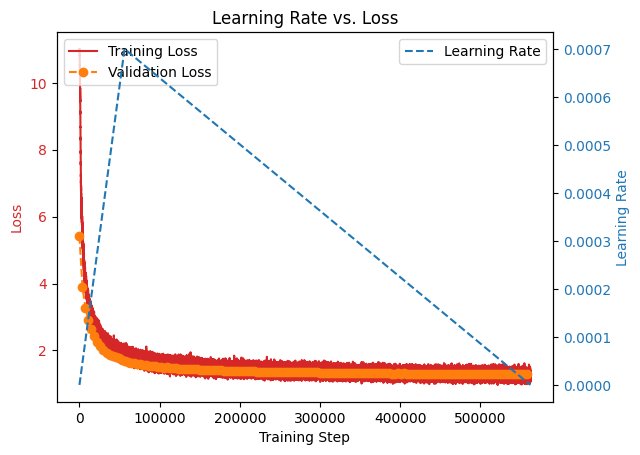

In [23]:
from matplotlib import pyplot as plt

# Ensure all histories are properly formatted
assert len(lr_history) == len(
    loss_history
), "Length of lr_history and loss_history must be the same"

# Create figure and primary y-axis for Loss
fig, ax1 = plt.subplots()

ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(len(loss_history)), loss_history, color="tab:red", label="Training Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Plot validation loss (assuming it occurs every 'epoch_interval' steps)
epoch_interval = len(loss_history) // len(val_loss_history)
val_x = [
    i * epoch_interval for i in range(len(val_loss_history))
]  # X values for validation loss
ax1.plot(
    val_x,
    val_loss_history,
    color="tab:orange",
    marker="o",
    linestyle="dashed",
    label="Validation Loss",
)

# Create secondary y-axis for Learning Rate
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="tab:blue")
ax2.plot(
    range(len(lr_history)),
    lr_history,
    color="tab:blue",
    linestyle="--",
    label="Learning Rate",
)
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# Model inference

In [91]:
def inference(input, tokenizer, model, max_length=TGT_MAX_SEQ):
    """
    Translates a single Polish sentence into Ukrainian using greedy decoding.
    """
    model.eval()  # Set the model to evaluation mode

    tokens = tokenizer.encode(input)
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    # print(tokens)

    # Start with the input sentence and an empty target sequence
    src_data = tokens
    tgt_data = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            output = model(src_data, tgt_data)

            next_token_id = output[:, -1, :].argmax(dim=-1).item()

            tgt_data = torch.cat([tgt_data, torch.tensor([[next_token_id]]).to(device)], dim=1)

            if next_token_id == tokenizer.eos_token_id:
                break

    # Decode the token ids back to the sentence
    translated_tokens = tgt_data.squeeze().tolist()
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


def inference_from_datasets(train_dataset: bool = True, index: int = 0) -> (str, str):
    if train_dataset:
        dataset = train_loader.dataset
    else:
        dataset = val_loader.dataset
    src_input = tokenizer.decode(dataset[index][0].tolist(), skip_special_tokens=True)
    translation = inference(src_input, tokenizer, transformer)

    print('Dataset:', 'Train' if train_dataset else 'Validation')
    print('Src:', src_input)
    print('Generated translation:', translation)
    real_translation = tokenizer.decode(dataset[index][1].tolist(), skip_special_tokens=True)
    print('Real translation:      ', real_translation)
    return src_input, translation, real_translation

<!-- # SacreBLEU metrics -->

In [92]:
import evaluate
import httpx
# Load metrics
rouge = evaluate.load("rouge")
sacrebleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")
chrf = evaluate.load("chrf")
bleu = evaluate.load("bleu")

[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [94]:

# Docs: https://huggingface.co/spaces/evaluate-metric/sacrebleu
# score from 0 to 100
local_accuracy = 0.0
deepl_accuracy = 0.0

def compute(predictions, references):
    # Predictions and references
    predictions = [predictions]
    references = [[references]]

    # Compute all metrics
    results_rouge = rouge.compute(predictions=predictions, references=references)  # ROUGE expects list of strings
    results_sacrebleu = sacrebleu.compute(predictions=predictions, references=references)
    results_meteor = meteor.compute(predictions=predictions, references=references)
    results_chrf = chrf.compute(predictions=predictions, references=references)
    results_bleu = bleu.compute(predictions=predictions, references=references)
    return results_rouge['rouge1']

    # Print results
    # print("\n📊 Translation Metrics:")
    # print(f"ROUGE-1 (0–1):        {results_rouge['rouge1']:.4f}")  # Overlap of unigrams (single words) between the generated and reference texts.
    # print(f"ROUGE-2 (0–1):        {results_rouge['rouge2']:.4f}")  # Overlap of bigrams (word pairs).
    # print(f"ROUGE-L (0–1):        {results_rouge['rougeL']:.4f}")  # Measures longest common subsequence (sequence similarity).
    # print(f"SacreBLEU (0–100):    {results_sacrebleu['score']:.2f}")  # Precision-based score for how many matching words/phrases, adjusted for brevity.
    # print(f"METEOR (0–1):         {results_meteor['meteor']:.4f}")  #  Considers word matches, stemming, and synonyms with penalties for word order.
    # print(f"chrF (0–100):         {results_chrf['score']:.2f}")  # Measures character-level n-gram overlap (more sensitive to small variations).
    # print(f"BLEU (0–100):         {results_bleu['bleu']:.2f}")  # Measures n-gram overlap between generated and reference texts.

n = 100
for i in range(n):
    src_input, predictions, references = inference_from_datasets(train_dataset=False, index=i)  # translation, real_translation


    json_data = {
        "text": [src_input], 
        "target_lang": "FR"
    }
    headers = {"Authorization": "DeepL-Auth-Key 8a886374-aa90-488e-8209-a000d7ac9e93:fx"}
    response = httpx.post("https://api-free.deepl.com/v2/translate", json=json_data, headers=headers)
    response = response.json()["translations"][0]["text"]
    print('Translation from DeepL:', response)

    local_accuracy += compute(predictions, references)
    print('DEEEPL')
    print()
    deepl_accuracy += compute(predictions, response)

print('Local accuracy:', local_accuracy/n)
print('DeepL accuracy:', deepl_accuracy/n)

Dataset: Validation
Src: zone de service; carré service attempt
Generated translation: somme de service; tâche de service
Real translation:       short serve service de côté; service latéral
Translation from DeepL: zone de service; carré service attempt
DEEEPL

Dataset: Validation
Src: New product and growers are not familiar with it.
Generated translation: Les nouveaux produits et les producteurs ne connaissent pas.
Real translation:       complexe II de la respiration fongique (succinate déshydrogénase); 7
Translation from DeepL: Il s'agit d'un nouveau produit que les producteurs ne connaissent pas.
DEEEPL

Dataset: Validation
Src: Would the answer be different if Canada were to enter into an agreement under Article 11 of the Directive?
Generated translation: La réponse est-elle différente si le Canada devait entrer dans une entente en vertu de l'article 11 de la Directive?
Real translation:       La réponse serait-elle différente si le Canada concluait un accord aux termes de l'arti

In [26]:
# PATH = r"new_translation_model.pt"
# torch.save(transformer.state_dict(), PATH)

In [27]:
# next_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
#                          max_tgt_seq_len, dropout)
# next_model.load_state_dict(torch.load(PATH, weights_only=True))
# next_model = next_model.to(device)
# # print(next_model)

# # sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "What are light beans there?"
# print(sentence)
# # sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
# translation = translate_sentence(sentence, tokenizer, next_model)
# print(translation)